In [100]:
%matplotlib inline

In [101]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from scipy import stats

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

#print data
data =  np.asmatrix(data)

np.random.shuffle(data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))




kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10).fit(data)
kmeans.fit(data)

print len(kmeans.cluster_centers_)
#print kmeans.cluster_centers_

n_digits: 10, 	 n_samples 1797, 	 n_features 64
10


In [102]:
# The value of InitNumber is chosen to be as large as permitted by the computational complexity of a k-means 
# algorithm creating q clusters.
InitNumber = 100

q = 20 #number of micro-clusters

starter_dataset = data[0:InitNumber,:]
stream_data = data[InitNumber:len(data),:]

In [103]:
kmeans = KMeans(init='k-means++', n_clusters=q).fit(starter_dataset)

starter_clusters = kmeans.cluster_centers_

In [104]:
#micro-cluster tuple (CF2x, CF1x, CF2t, CF1t, n)
micro_clusters = [None]*q

for i in range(0,len(starter_dataset)):
    starter_point = np.array(starter_dataset[i])
    #get minimum euclidean distance cluster
    dist = [ np.linalg.norm(starter_point - cluster) for cluster in starter_clusters ]
    cluster_id = np.argmin(dist)
    
    #add to micro-cluster
    cluster_tuple = np.array([np.square(starter_point),starter_point,np.square(i), i, 1]) 
    if (micro_clusters[cluster_id] == None): 
        micro_clusters[cluster_id] = cluster_tuple
    else:
        micro_clusters[cluster_id] = micro_clusters[cluster_id] + cluster_tuple
        


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [105]:
print micro_clusters

[array([ array([[  0.00000000e+00,   1.68354070e+00,   5.16318882e+00,
          5.74264801e+00,   1.05173593e+01,   7.54082105e+00,
          2.38702162e+00,   2.34460970e-01,   5.23523663e-02,
          7.84529014e+00,   9.29410701e+00,   1.18033933e+01,
          9.54463734e+00,   1.22170184e+01,   6.18594270e+00,
          2.55193002e-01,   2.98709575e-02,   1.93624471e+01,
          9.50046039e+00,   1.69225440e+01,   1.26750840e+01,
          1.70376719e+01,   3.91641712e+00,   1.95699444e-01,
          1.67130919e-02,   6.12841708e+00,   1.37796874e+01,
          8.57970061e+00,   9.66717021e+00,   1.87844860e+01,
          7.47397595e+00,   3.34634690e-02,   0.00000000e+00,
          6.78126714e+00,   1.57021146e+01,   1.42480462e+01,
          1.42162368e+01,   1.54699738e+01,   9.81624552e+00,
          0.00000000e+00,   5.64456857e-02,   4.23394189e+00,
          1.38889167e+01,   1.72185691e+01,   1.52178014e+01,
          1.38131654e+01,   1.37259899e+01,   1.18126119e-01,

In [106]:
def calcSSQ(points, centroids, horizon):
    SSQ = 0
    for point in points[(-1*horizon):]:
        dist = [ np.linalg.norm(point - cluster) for cluster in starter_clusters ]
        SSQ += np.square(min(dist))
    print "SSQ: " + str(SSQ)
    
    return SSQ

In [113]:
# t -      maximal boundary factor
#          The maximum boundary of the micro-cluster is defined as 
#          a factor of t of the RMS deviation of the data points in the cluster from the centroid. 
#          We define this as the maximal boundary factor.
#
# r -      heuristic maximal boundary factor
#          default value = 2
#          For a cluster which contains only 1 point, 
#          the maximum boundary is choosen to be r times the maximum boundary of the next closest cluster.
#
# m -      approximation detail for timestamp
#          m last data points of the micro-cluster
#
# delta -  When the least relevance stamp of any micro-cluster is below a user-defined threshold delta, 
#          it can be eliminated and a new micro-cluster can be created with a unique id 
#          corresponding to the newly arrived data point

def CluStream(record, timestep, micro_clusters, t = 2, r = 2, m = 10, delta = 10):
    Xik = np.array(record)
    #get minimum euclidean distance cluster
    #                              centroid M = CF1x / n
    dist = [ np.linalg.norm(Xik - (cluster[1] / cluster[4])) for cluster in micro_clusters ]
    
    dist_sorted = np.argsort(dist)
    
    cluster = dist_sorted[0]
    
    i = 0
    while True:
        cluster_id = dist_sorted[i]
    
        n = micro_clusters[cluster_id][4]

        if n > 1:
            #RMS deviation
            squared_sum = np.square(micro_clusters[cluster_id][1])
            sum_of_squared = micro_clusters[cluster_id][0]

            RMSD = np.sqrt(np.abs(sum_of_squared - (squared_sum / n)))

            maximal_boundary = np.linalg.norm(RMSD) * t
            
            if i > 0:
                maximal_boundary *= r
                
            break
            
        #find next closest cluster
        i += 1
        
    if dist[cluster] <= maximal_boundary: #data point falls within the maximum boundary of the micro-cluster
        #data point is added to the micro-cluster
        micro_clusters[cluster] = micro_clusters[cluster] + \
                                    np.array([np.square(Xik), Xik, np.square(timestep), timestep, 1])
        print "add to cluster"
    else: #create a new micro-cluster
          #determine if it is safe to delete any of the current micro-clusters as outliers
        mean_timestamp = [ (cluster[3] / cluster[4]) for cluster in micro_clusters ]
        standard_deviation_timestamp = [ np.sqrt((cluster[2] / cluster[4]) - np.square((cluster[3] / cluster[4]))) \
                                         for cluster in micro_clusters ]
        
        Z = []
        for i in range(0, len(micro_clusters)):
            mc = m
            if mc > micro_clusters[i][4]:
                mc = micro_clusters[i][4]
                
            Z.append(m / (2 * micro_clusters[i][4]))
        
        Z = np.array(Z)
        
        relevance_stamp = mean_timestamp + Z * standard_deviation_timestamp
        
        least_recent_cluster = np.argmin(relevance_stamp)
        
        print relevance_stamp[least_recent_cluster]
        
        if relevance_stamp[least_recent_cluster] < delta: #eliminate old cluster and create a new micro-cluster
            micro_clusters[least_recent_cluster] = np.array([np.square(Xik), Xik, np.square(timestep), timestep, 1])
            print "eliminated cluster"
        else: #merge the two micro-clusters which are closest to one another
            #search for two closest clusters
            minA_id = -1
            minB_id = -1
            min_dist = float("inf")
            for a in range (0, len(micro_clusters)):
                for b in range (a + 1, len(micro_clusters)):
                    d = np.linalg.norm((micro_clusters[b][1] / micro_clusters[b][4]) - \
                                       (micro_clusters[a][1] / micro_clusters[a][4]))
                    if d < min_dist:
                        minA_id = a
                        minB_id = b
                        min_dist = d
            #merge them            
            micro_clusters[minA_id] = micro_clusters[minA_id] + micro_clusters[minB_id]
            
            #create new cluster
            micro_clusters[minB_id] = np.array([np.square(Xik), Xik, np.square(timestep), timestep, 1])
            print "merged cluster"
        
    return micro_clusters

In [114]:
SSQ_kmeans = [] 
for i in range(0, len(stream_data)):
    SSQ_kmeans.append(calcSSQ((stream_data[0:(i+1)]), micro_clusters,100))

SSQ: 23.775878848
SSQ: 53.9086292843
SSQ: 96.718953033
SSQ: 129.961488872
SSQ: 170.227492349
SSQ: 214.003619503
SSQ: 231.461440817
SSQ: 269.58368091
SSQ: 289.326575654
SSQ: 376.014987929
SSQ: 425.526720887
SSQ: 436.247006792
SSQ: 463.518236093
SSQ: 491.390485478
SSQ: 510.976661654
SSQ: 530.17932134
SSQ: 571.79256228
SSQ: 663.216403454
SSQ: 697.839273837
SSQ: 749.533034458
SSQ: 776.062074538
SSQ: 790.564278637
SSQ: 819.090889411
SSQ: 876.400176929
SSQ: 939.207455464
SSQ: 966.545590023
SSQ: 1007.87992774
SSQ: 1032.86806805
SSQ: 1084.74751532
SSQ: 1124.27410171
SSQ: 1221.54067757
SSQ: 1266.40797896
SSQ: 1297.90149783
SSQ: 1333.91294665
SSQ: 1346.60408285
SSQ: 1358.15770286
SSQ: 1368.01582685
SSQ: 1382.44441309
SSQ: 1420.62386974
SSQ: 1461.9973629
SSQ: 1485.63668185
SSQ: 1493.92721322
SSQ: 1517.43536376
SSQ: 1538.29028184
SSQ: 1559.61324898
SSQ: 1593.79563094
SSQ: 1620.03896255
SSQ: 1647.70381719
SSQ: 1666.97262932
SSQ: 1706.05002803
SSQ: 1741.83350078
SSQ: 1758.33979856
SSQ: 1776.90942928

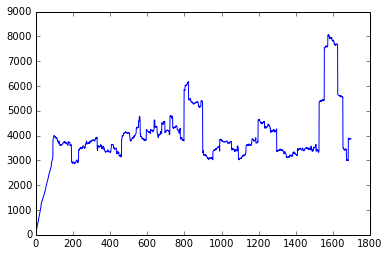

3929.7193057567065

In [115]:
plt.plot(SSQ_kmeans)
plt.show()
np.mean(SSQ_kmeans)

In [116]:
SSQ = []
for i in range(0, len(stream_data)):
    micro_clusters = CluStream(stream_data[i], i, micro_clusters)
    SSQ.append(calcSSQ((stream_data[0:(i+1)]), micro_clusters,100))

add to cluster
SSQ: 23.775878848
add to cluster
SSQ: 53.9086292843
add to cluster
SSQ: 96.718953033
add to cluster
SSQ: 129.961488872
add to cluster
SSQ: 170.227492349
add to cluster
SSQ: 214.003619503
add to cluster
SSQ: 231.461440817
add to cluster
SSQ: 269.58368091
add to cluster
SSQ: 289.326575654
add to cluster
SSQ: 376.014987929
add to cluster
SSQ: 425.526720887
add to cluster
SSQ: 436.247006792
add to cluster
SSQ: 463.518236093
add to cluster
SSQ: 491.390485478
add to cluster
SSQ: 510.976661654
add to cluster
SSQ: 530.17932134
add to cluster
SSQ: 571.79256228
add to cluster
SSQ: 663.216403454
add to cluster
SSQ: 697.839273837
add to cluster
SSQ: 749.533034458
add to cluster
SSQ: 776.062074538
add to cluster
SSQ: 790.564278637
add to cluster
SSQ: 819.090889411
add to cluster
SSQ: 876.400176929
add to cluster
SSQ: 939.207455464
add to cluster
SSQ: 966.545590023
add to cluster
SSQ: 1007.87992774
add to cluster
SSQ: 1032.86806805
add to cluster
SSQ: 1084.74751532
add to cluster
SSQ:

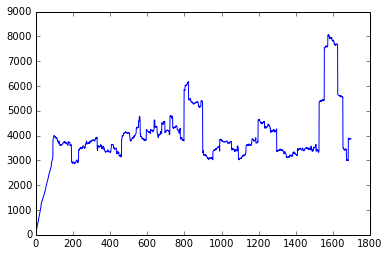

In [117]:
plt.plot(SSQ)
plt.show()

In [112]:
np.mean(SSQ)

3929.7193057567065